In [1]:
from weac_2.components import (
    Layer,
    WeakLayer,
    Segment,
    CriteriaConfig,
    ModelInput,
    ScenarioConfig,
)
from weac_2.core import SystemModel, Scenario, Slab
from weac_2.analysis import (
    CriteriaEvaluator,
    Plotter,
    CoupledCriterionResult,
    CoupledCriterionHistory,
    FindMinimumForceResult,
)

In [2]:
layers = [
    Layer(rho=350, h=120),
    Layer(rho=270, h=120),
    Layer(rho=180, h=120),
]
scenario_config = ScenarioConfig(
    system_type="skier",
    # phi=-35,
    phi=22,
)
segments = [
    Segment(length=180000, has_foundation=True, m=0),
    Segment(length=0, has_foundation=False, m=50),
    Segment(length=0, has_foundation=False, m=0),
    Segment(length=180000, has_foundation=True, m=0),
]
weak_layer = WeakLayer(
    rho=125,
    h=20,
    E=1,
)
criteria_config = CriteriaConfig(
    stress_envelope_method="adam_unpublished",
    scaling_factor=125 / 250,
    order_of_magnitude=3,
)
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    segments=segments,
    weak_layer=weak_layer,
    criteria_config=criteria_config,
)

system = SystemModel(model_input=model_input)
criteria_evaluator = CriteriaEvaluator(criteria_config=criteria_config)

In [3]:
coupled_criterion_result: CoupledCriterionResult = (
    criteria_evaluator.evaluate_coupled_criterion(system)
)

# print("Algorithm convergence:", coupled_criterion_result.converged)
print("Message:", coupled_criterion_result.message)
print("Critical skier weight:", coupled_criterion_result.critical_skier_weight)
print("Crack length:", coupled_criterion_result.crack_length)
print("CCR Segments: ", coupled_criterion_result.final_system.scenario.segments)
# print("G delta:", coupled_criterion_result.g_delta)
# print("Iterations:", coupled_criterion_result.iterations)
# print("dist_ERR_envelope:", coupled_criterion_result.dist_ERR_envelope)
# print("History:", coupled_criterion_result.history.incr_energies[-1])

system = coupled_criterion_result.final_system
g_delta, propagation_status = criteria_evaluator.check_crack_self_propagation(
    system, rm_skier_weight=True
)
print("Results of crack propagation criterion: ", propagation_status)
print("G delta: ", g_delta)
g_delta, propagation_status = criteria_evaluator.check_crack_self_propagation(
    system, rm_skier_weight=False
)
print("Results of crack propagation criterion: ", propagation_status)
print("G delta: ", g_delta)
print("CCSP Segments: ", system.scenario.segments)

min_force_result: FindMinimumForceResult = criteria_evaluator.find_minimum_force(system)
system.update_scenario(segments=min_force_result.old_segments)
print("Minimum force result:", min_force_result)
print("MFR Segments: ", system.scenario.segments)

min_crack_length: float = criteria_evaluator.find_minimum_crack_length(system)
print("min crack length:", min_crack_length)
print("MCL Segments: ", system.scenario.segments)

skier_weight = min_force_result.critical_skier_weight + 20
new_crack_length, new_segments = criteria_evaluator.find_crack_length_for_weight(
    system, skier_weight
)
print("New crack length:", new_crack_length)
print("CLFW Segments: ", new_segments)

Message: No Exception encountered - Converged successfully.
Critical skier weight: 96.19060064865761
Crack length: 1575.220919682266
CCR Segments:  [Segment(length=179054.83383146112, has_foundation=True, m=0.0), Segment(length=945.1661685388826, has_foundation=False, m=96.19060064865761), Segment(length=630.0547511433833, has_foundation=False, m=0.0), Segment(length=179369.94524885662, has_foundation=True, m=0.0)]
Segments:  [Segment(length=179054.83383146112, has_foundation=True, m=0.0), Segment(length=945.1661685388826, has_foundation=False, m=96.19060064865761), Segment(length=630.0547511433833, has_foundation=False, m=0.0), Segment(length=179369.94524885662, has_foundation=True, m=0.0)]
Results of crack propagation criterion:  False
G delta:  0.30998010075663973
Segments:  [Segment(length=179054.83383146112, has_foundation=True, m=0.0), Segment(length=945.1661685388826, has_foundation=False, m=96.19060064865761), Segment(length=630.0547511433833, has_foundation=False, m=0.0), Segm

   - Generating stress envelope...
   - Generating fracture toughness envelope...
Prior to Plot Segments:  [Segment(length=180000.0, has_foundation=True, m=0.0), Segment(length=0.0, has_foundation=False, m=50.0), Segment(length=0.0, has_foundation=False, m=0.0), Segment(length=180000.0, has_foundation=True, m=0.0)]
   - Analysis Plot...
System Segments:  [Segment(length=180000.0, has_foundation=True, m=0.0), Segment(length=0.0, has_foundation=False, m=50.0), Segment(length=0.0, has_foundation=False, m=0.0), Segment(length=180000.0, has_foundation=True, m=0.0)]


/home/pillowbeast/Documents/weac/weac_2/analysis/plotter.py:1385: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(
/home/pillowbeast/Documents/weac/weac_2/analysis/plotter.py:1393: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(


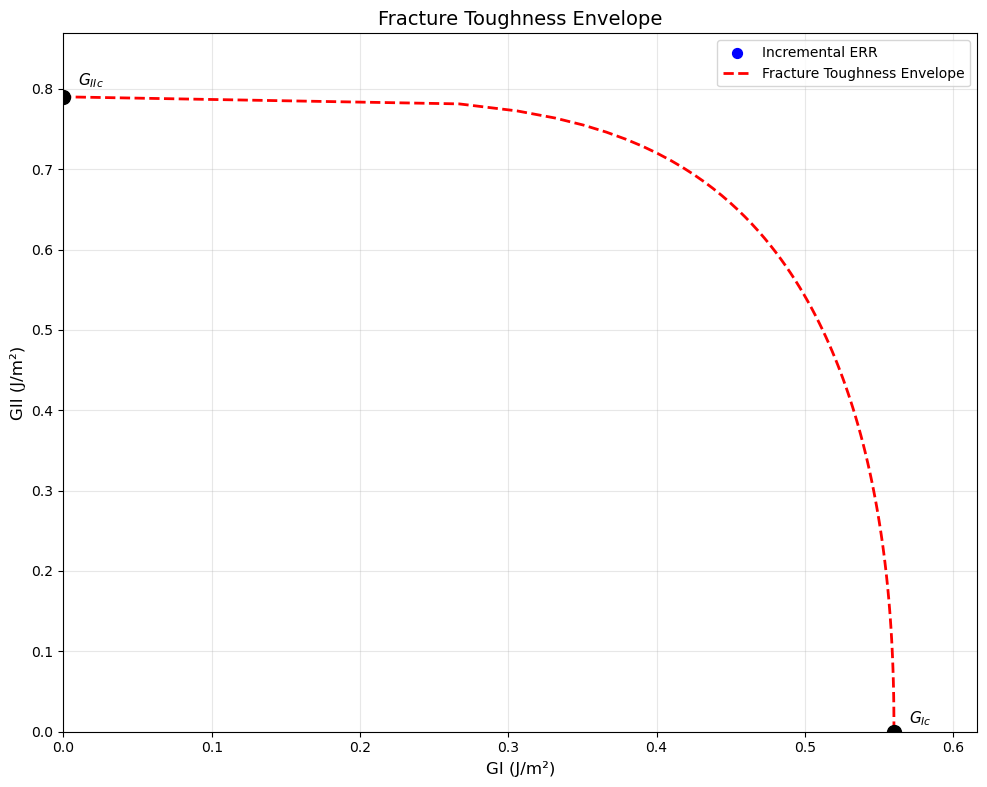

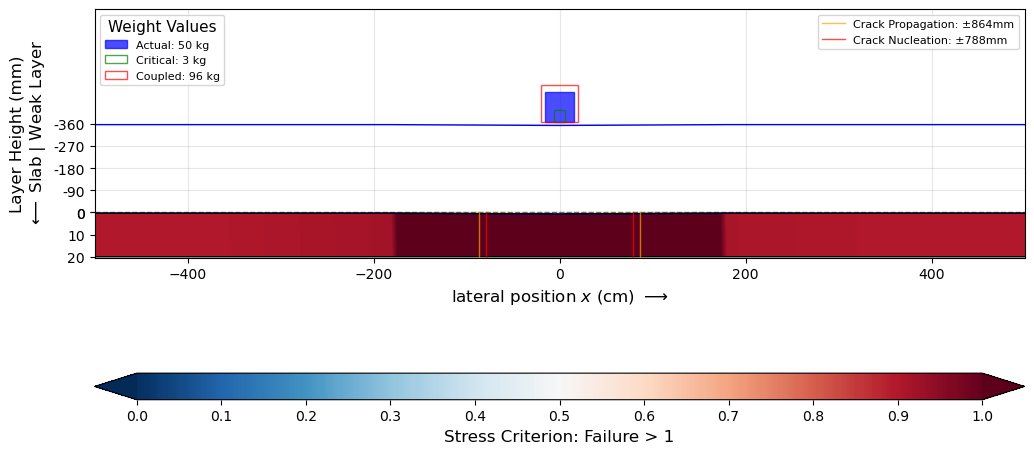

In [7]:
print("   - Generating stress envelope...")
plotter = Plotter()
fig1 = plotter.plot_stress_envelope(
    system_model=system,
    criteria_evaluator=criteria_evaluator,
    all_envelopes=False,
    filename="stress_envelope",
)

print("   - Generating fracture toughness envelope...")
fig2 = plotter.plot_err_envelope(
    system_model=system,
    criteria_evaluator=criteria_evaluator,
    filename="err_envelope",
)

# fig1.savefig("stress_envelope.png")
# fig2.savefig("err_envelope.png")

print("Prior to Plot Segments: ", system.scenario.segments)
system.update_scenario(segments=segments)

print("   - Analysis Plot...")
fig3 = plotter.plot_analysis(
    system=system,
    criteria_evaluator=criteria_evaluator,
    min_force_result=min_force_result,
    min_crack_length=min_crack_length[0],
    coupled_criterion_result=coupled_criterion_result,
    filename="analysis",
    deformation_scale=500.0,
)
